# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением *accuracy*.

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# загрузим файл с данными
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Введение_в_машинное_обучение/users_behavior.csv')

df.info()
df.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
127,68.0,444.41,35.0,26460.37,1


**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:

* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
# количество пользователей по тарифам
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Тарифом "Смарт" пользуется около 70% клиентов, остальные - "Ультра".

In [4]:
# описательные статистики
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Данные предварительно обработаны, пропусков нет, нужный формат данных.

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


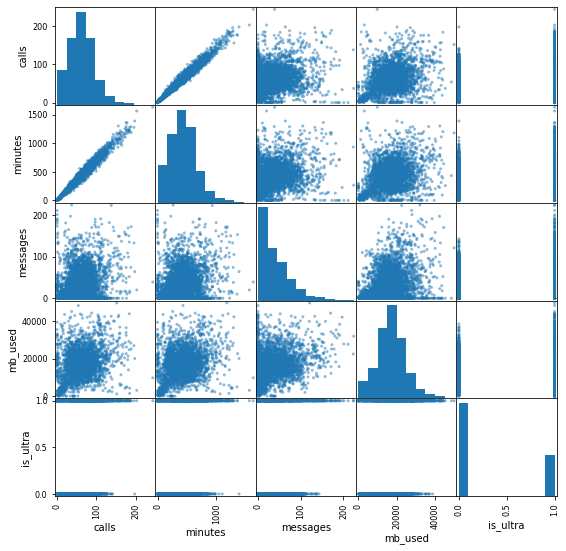

In [5]:
# диаграмма рассеяния и коэффициент корреляции
pd.plotting.scatter_matrix(df, figsize=(9, 9))
df.corr()

## Разбиение данных на выборки

Спрятанной тестовой выборки нет, данные разобъём на три части: обучающую, валидационную и тестовую выборки, в соотношении 3:1:1.

In [6]:
# разделение проведём с помощью функции train_test_split библиотеки sklearn
df_train, df_rest = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra'])
df_valid, df_test = train_test_split(df_rest, test_size=0.5, random_state=12345)

print(f'Обучающая: {df_train.shape[0] / len(df):.1%}')
print(f'Валидационная: {df_valid.shape[0] / len(df):.1%}')
print(f'Тестовая: {df_test.shape[0] / len(df):.1%}')

Обучающая: 60.0%
Валидационная: 20.0%
Тестовая: 20.0%


In [7]:
# запишем признаки и целевой признак в отдельные переменные
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']
display(features_train.sample())
display(target_train.sample())
display(features_valid.sample())
display(target_valid.sample())
display(features_test.sample())
target_test.sample()

,calls,minutes,messages,mb_used
1309,70.0,533.41,54.0,20011.87


2041    1
Name: is_ultra, dtype: int64

,calls,minutes,messages,mb_used
2085,74.0,468.26,49.0,19013.03


179    0
Name: is_ultra, dtype: int64

,calls,minutes,messages,mb_used
1551,74.0,555.25,27.0,25718.19


722    1
Name: is_ultra, dtype: int64

Разделили данные на три части и выделили признаки и целевой признак в отдельные переменные у обучающей и валидационной выборок:
* `df_train` - обучающая (`60%`)
* * `features_train` - признаки: `calls`, `minutes`, `messages`, `mb_used`
* * `target_train` - целевой признак: `is_ultra`
* `df_valid` - валидационная (`20%`)
* * `features_valid` - признаки: `calls`, `minutes`, `messages`, `mb_used`
* * `target_valid` - целевой признак: `is_ultra`
* `df_test` - тестовая (`20%`)

## Исследование моделей

### Решающее дерево

In [8]:
# модель решающего дерева DecisionTreeClassifier
# гиперпараметр max_depth - максимальная глубина дерева
for depth in range(1, 4):
    best_depth = []
    best_result = 0
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    if accuracy > best_result:
                    best_depth = [depth]
                    best_result = accuracy
print('''Наилучшая точность: {}
Параметры модели:
   max_depth = {} '''.format(round(best_result, 2), best_depth[0]))

Наилучшая точность: 0.8
Параметры модели:
   max_depth = 3 


Модель решающего дерева выдала результат с долей правильных ответов более `0.75`:  `0.79`.

### Случайный лес

In [9]:
# модель случайного леса RandomForestClassifier
# гиперпараметр n_estimators - количество деревьев
for est in range(1, 20):
    best_p = []
    best_result = 0
    for depth in range(1, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid) 
        if result > best_result:
            best_p = [est, depth]
            best_result = result
print('''Наилучшая точность: {}
Параметры модели:
   n_estimators = {}
   max_depth = {}'''.format(round(best_result, 2), best_p[0], best_p[1]))

Наилучшая точность: 0.82
Параметры модели:
   n_estimators = 19
   max_depth = 11


Модель случайного леса выдала результат с долей правильных ответов более `0.75`:  `0.81`.

### Логистическая регрессия

In [10]:
# модель логистической регрессии LogisticRegression
# гиперпараметры: solver='lbfgs' — «Lbfgs» - это алгоритм оптимизации, который аппроксимирует
# алгоритм Бройдена – Флетчера – Гольдфарба – Шанно, который относится к квазиньютоновским методам.
# рекомендуется использовать для небольших наборов данных, чтобы не страдала его производительность.
# гиперпараметр max_iter - максимальное количество итераций обучения
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000, penalty='none')
model.fit(features_train, target_train)
result_logis = model.score(features_valid, target_valid)
print('''Точность: {}
Параметры модели:
   solver='lbfgs'
   max_iter=1000 '''.format(round(result_logis, 2)))

Точность: 0.74
Параметры модели:
   solver='lbfgs'
   max_iter=1000 


Модель логистической регрессии выдала результат с долей правильных ответов более `0.75`: `0.76`.

**Вывод**  
 
Подходящими являются модели:
* решающего дерева `DecisionTreeClassifier`:
* * точность: `0.79`
* * параметр: `max_depth = 3`. 
* случайного леса `RandomForestClassifier`:
* * точность: `0.81`
* * параметр: `n_estimators = 19`
* * параметр: `max_depth = 12`

Неподходящая модель:
* логистической регрессии `LogisticRegression`:
* * точность: `0.71`
* * параметры: `solver = 'lbfgs'`, `max_iter = 1000 `.

## Проверка моделей на тестовой выборке

In [12]:
# модель решающего дерева DecisionTreeClassifier
# гиперпараметр max_depth = 3
model_1 = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_1.fit(features_train, target_train)
result_test_dtc = model_1.score(features_test, target_test)
print('''Точность: {}
Параметры модели:
   max_depth=3 '''.format(round(result_test_dtc, 2)))

Точность: 0.78
Параметры модели:
   max_depth=3 


In [13]:
# модель случайного леса RandomForestClassifier
# гиперпараметр n_estimators = 10
model_2 = RandomForestClassifier(random_state=12345, n_estimators=19, max_depth=12)
model_2.fit(features_train, target_train)
result_test_rfc = model_2.score(features_test, target_test)
print('''Точность: {}
Параметры модели:
   n_estimators=19
   max_depth=12 '''.format(round(result_test_rfc, 2)))

Точность: 0.81
Параметры модели:
   n_estimators=19
   max_depth=12 


**Вывод**  

На тестовой выборке модели решающего леса и случайного дерева отработали с одинаковой точностью, потеряв при этом в точности `0.01`.
Получившаяся максимальная точность: `0.8` больше необходимой точности `0.75`.

Были проанализированы различные классификационные модели:
* решающее дерево `DecisionTreeClassifier`,
* случайный лес `RandomForestClassifier`,
* логистическая регрессия `LogisticRegression`.  

Каждая модель была обучена для различных сочетаний гиперпараметров, получены лучшие варианты для каждой модели.  
Высшую точность (`accuracy`) достигла модель `RandomForestClassifier` .  
`Accuracy` на валидационной выборке: `0.81` .  
`Accuracy` на тестовой выборке: `0.8` .

## Проверка модели на адекватность

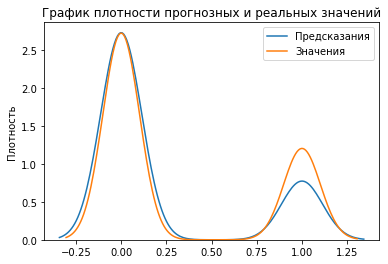

In [14]:
# построим график плотности предсказаний и реальных значений
model_a = RandomForestClassifier(random_state=12345, n_estimators=19, max_depth=12)
model_a.fit(features_train, target_train)
model_a_g = model_a.predict(features_test)

sns.kdeplot(model_a_g)
sns.kdeplot(target_train)

plt.legend(['Предсказания','Значения'], loc=1)
plt.xlabel(''); plt.ylabel('Плотность');
plt.title('График плотности прогнозных и реальных значений');

Хорошо заметны распределения между разными тарифами, в зависимости от количества пользователей. 
Есть два значения целевого признака `is_ultra`: `1` и `0`. Если модель предсказывает одно из двух чисел случайным образом, значение ее точности будет 0.5. У модели случайного леса точность `0.8`, что говорит об адекватности модели.

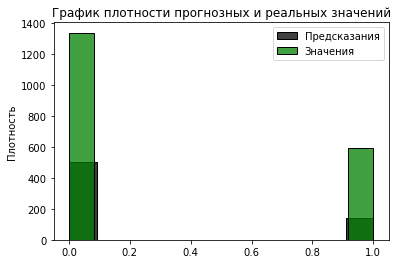

In [15]:
# график histplot
model_a = RandomForestClassifier(random_state=12345, n_estimators=19, max_depth=12)
model_a.fit(features_train, target_train)
model_a_g = model_a.predict(features_test)

sns.histplot(model_a_g, color='k')
sns.histplot(target_train, color='g')

plt.legend(['Предсказания','Значения'], loc=1)
plt.xlabel(''); plt.ylabel('Плотность');
plt.title('График плотности прогнозных и реальных значений');

In [16]:
# матрица классификации(ошибок/путаницы)
from sklearn import metrics
pred = model_a_g
actual = target_test
CM = metrics.confusion_matrix(pred, actual).ravel()

print(CM)
report = metrics.classification_report(pred, actual)
print(report)

[412  89  35 107]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       501
           1       0.55      0.75      0.63       142

    accuracy                           0.81       643
   macro avg       0.73      0.79      0.75       643
weighted avg       0.84      0.81      0.82       643

